# Lab 2: Supernovae

## Goals of this lab: 

* Understand how to track the evolution of a binary system using `track_interpolation` and specifying the desired number of time steps (`n_o_steps_history`).

* Become familiar with the `step_SN` parameters (kicks, SN perscriptions) in POSYDON and explore how they influence the evolution of a binary system.

* Learn about the available `SN_MODELS` (i.e. set of parameter assumptions)  in POSYDON and understand how to run them based on different interpolation methods.

* Extract stellar profiles and understand how a black hole spin is calculated


# 1. Evolve one binary system


We will evolve one binary system using the default POSYDON .ini file, as you did in Lab 2.2 on Tuesday.  

This time, let’s consider a binary with the following initial parameters: **$M_{1,init} = 28.15  M_{\odot}$, $M_{2,init} = 19.7  M_{\odot}$, and $P_{\text{orb,init}} = 10$ days**.

## Define the initial values here

In [11]:
m1_init = 28.15 # in Msun
m2_init = 19.7 # in Msun
p_init = 10 # in days

## Load the steps from ini.file

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import pandas as pd
from posydon.config import PATH_TO_POSYDON
from posydon.popsyn.io import simprop_kwargs_from_ini
path_to_default_ini = os
from posydon.popsyn.io import simprop_kwargs_from_ini
from posydon.binary_evol.simulationproperties import SimulationProperties
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.MESA.step_mesa import MS_MS_step
from posydon.binary_evol.MESA.step_mesa import CO_HeMS_step
from posydon.binary_evol.MESA.step_mesa import CO_HMS_RLO_step
from posydon.binary_evol.MESA.step_mesa import CO_HeMS_RLO_step
from posydon.binary_evol.DT.step_detached import detached_step
from posydon.binary_evol.DT.step_disrupted import DisruptedStep
from posydon.binary_evol.DT.step_merged import MergedStep
from posydon.binary_evol.DT.step_initially_single import InitiallySingleStep
from posydon.binary_evol.SN.step_SN import StepSN

# Get the environment variable PATH_TO_POSYDON
base_dir = os.environ["PATH_TO_POSYDON"]
path_to_ini = os.path.join(base_dir, "posydon/popsyn/population_params_default.ini")

sim_prop = SimulationProperties.from_ini(path_to_ini, load_steps=True, metallicity=1, verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
STEP NAME           STEP FUNCTION            KWARGS
flow (<function flow_chart at 0x7f492a194fe0>, {})
step_HMS_HMS (<class 'posydon.binary_evol.MESA.step_mesa.MS_MS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False, 'metallicity': 1.0})
step_CO_HeMS (<class 'posydon.binary_evol.MESA.step_mesa.CO_HeMS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False, 'metallicity': 1.0})
step_

# Assigning a Specific Vector for CC1 Kick to Ensure Deterministic Evolution

By default, the supernova (SN) kick magnitude is sampled from a Maxwellian distribution with a random direction. To make the system’s evolution deterministic, we instead specify a fixed kick vector.

This is controlled through the `natal_kick_array`, which has four elements:

`natal_kick_array[0]`: kick magnitude (km/s)

`natal_kick_array[1]`: azimuthal angle (rad)

`natal_kick_array[2]`: polar angle (rad)

`natal_kick_array[3]`: orbital mean anomaly (rad) (relevant only for eccentric orbits)

For further details on evolving specific binaries with a fixed kick, see the documentation:  

https://posydon.org/POSYDON/latest/tutorials-examples/population-synthesis/evolve_single_binaries.html

In [13]:
natal_kick_array_selected = [41, 0., 0., 0.]

In [14]:

#from posydon.binary_evol.singlestar import SingleStar

dict_initial_binary = {'time': 0.0, 'state': 'detached', 'event': 'ZAMS', 'eccentricity': 0.0}

STAR1, STAR2 = SingleStar(**{'mass': m1_init, 'state': 'H-rich_Core_H_burning', 'natal_kick_array':natal_kick_array_selected}), \
               SingleStar(**{'mass': m2_init, 'state': 'H-rich_Core_H_burning'})
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)


## Evolve and specify the `scalar_names` for both the primary and secondary stars that you wish to include in the output. For (most of) the options available see: `population_params_default.ini`  
Next, evolve the binary system and track its evolution with the `plot_SN_evolution` function provided for this lab.
This function visualizes how the system evolves over time by plotting the total masses, helium core masses of the binary components as well as the orbital period, and eccentricity of the binary system.



In [15]:
S1_kwargs = {
    "only_select_columns": ["spin"],
    "scalar_names": ["natal_kick_array", "SN_type", "f_fb",'h1_mass_ej', 'he4_mass_ej', 'avg_c_in_c_core_at_He_depletion', 'co_core_mass_at_He_depletion']
}
S2_kwargs = S1_kwargs.copy()
binary.evolve()

df=binary.to_df(extra_columns={'step_names':'string'})
df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)

/home/qmh9626/miniconda/envs/posydon_env/lib/python3.11/site-packages/posydon/interpolation/IF_interpolation.py:1173: InterpolationWarning: '1NN interpolation used for 1 binaries out of hull. Parameter-wise distance (Unnormalized) for point with maximum out-of-hull euclidian distance (Normalized): [0.0129837  0.05643385 0.00012962]'


## Display the oneline dataframe columns saved

In [16]:
df_oneline.columns

Index(['state_i', 'event_i', 'time_i', 'separation_i', 'orbital_period_i',
       'eccentricity_i', 'rl_relative_overflow_1_i',
       'rl_relative_overflow_2_i', 'lg_mtransfer_rate_i',
       'mass_transfer_case_i', 'trap_radius_i', 'acc_radius_i',
       't_sync_rad_1_i', 't_sync_conv_1_i', 't_sync_rad_2_i',
       't_sync_conv_2_i', 'V_sys_x_i', 'V_sys_y_i', 'V_sys_z_i', 'NN_dist_x_i',
       'NN_dist_y_i', 'NN_dist_z_i', 'S1_spin_i', 'S2_spin_i', 'state_f',
       'event_f', 'time_f', 'separation_f', 'orbital_period_f',
       'eccentricity_f', 'rl_relative_overflow_1_f',
       'rl_relative_overflow_2_f', 'lg_mtransfer_rate_f',
       'mass_transfer_case_f', 'trap_radius_f', 'acc_radius_f',
       't_sync_rad_1_f', 't_sync_conv_1_f', 't_sync_rad_2_f',
       't_sync_conv_2_f', 'V_sys_x_f', 'V_sys_y_f', 'V_sys_z_f', 'NN_dist_x_f',
       'NN_dist_y_f', 'NN_dist_z_f', 'S1_spin_f', 'S2_spin_f',
       'S1_natal_kick_array_0', 'S1_natal_kick_array_1',
       'S1_natal_kick_array_2', '

In this Lab, we will make use of `plot_SN_evolution` for visualization, that can be foud locally, to visualize the time evolution of a system, focusing on its CC1/2 properties.

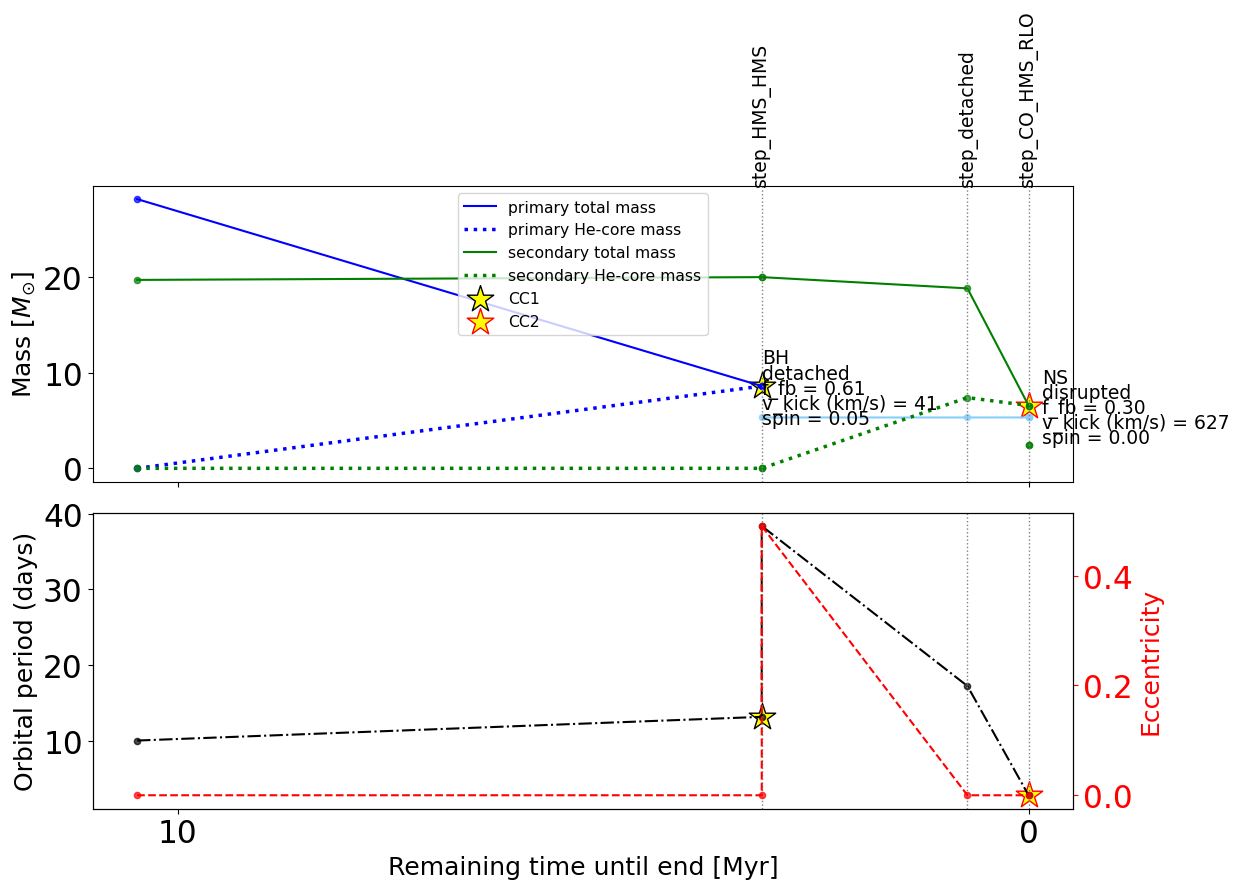

,step_names,state,time,S1_state,S2_state,event
binary_index,,,,,,
NaN,initial_cond,detached,0.000000e+00,H-rich_Core_H_burning,H-rich_Core_H_burning,ZAMS
NaN,step_HMS_HMS,detached,7.334459e+06,stripped_He_Core_C_depleted,H-rich_Core_H_burning,CC1
NaN,step_SN,detached,7.334459e+06,BH,H-rich_Core_H_burning,<NA>
NaN,step_detached,RLO2,9.749859e+06,BH,H-rich_Shell_H_burning,oRLO2
NaN,step_CO_HMS_RLO,detached,1.047772e+07,BH,stripped_He_Core_C_depleted,CC2
NaN,step_SN,disrupted,1.047772e+07,BH,NS,<NA>
NaN,step_end,disrupted,1.047772e+07,BH,NS,END


In [17]:
#### Plot without track_interpolation
from plotting_evolution_till_CC_one_system  import plot_SN_evolution # a function made for this lab to visualize the time evolution of a systems, focusing on its CC1/2 properties
plot_SN_evolution(df, df_oneline)
col=["step_names","state","time", "S1_state", "S2_state","event"]
df[col]

When visualizing the binary’s evolution over time, POSYDON outputs only final values (the outcome of a step) of each evolutionary step. Consequently, the detailed history of mass transfer and binary interactions is not resolved. Alongside this, we also show key properties of the system, including the nature of the compact object formed after CC1 or CC2, whether the system remains bound or becomes disrupted following compact object formation, as well as the natal kick imparted to the newly formed BH or NS and, in the case of a BH, its spin.

<div class="alert alert-success">

## Exercise: 
To become more familiar with commonly used supernova (SN) parameters and where they are stored (in the history or oneline keys), print key information for the system above. This should include the fallback fraction, the amounts of hydrogen and helium ejected during the SN event,  the kick magnitude at CC1, and whether the system was disrupted or remained bound after CC1.
   
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint 1 (click to reveal):</summary></b>
```
All this information is stored as columns in df_oneline except the step_names stored in df. The corresponding columns are organized as follows:

f_fb: fallback fraction

h1_mass_ej: hydrogen mass in the ejecta

he4_mass_ej: helium mass in the ejecta

magnitude of the kick: natal_kick_array_0

The state of the binary after CC1 is recorded in the step_names column at step_SN (i.e., the outcome of step_SN). NOT at the CC1 or CC2 event, (which calls the step_SN)
```
    
</details>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>
```

print("fallback fraction:", df_oneline["S1_f_fb"].values)
print("H mass in the ejecta in solar masses",df_oneline["S1_h1_mass_ej"].values)
print("He mass in the ejecta in solar masses", df_oneline["S1_he4_mass_ej"].values)
print("kick magnitude:",df_oneline["S1_natal_kick_array_0"].values)
post_CC1 = (df["step_names"] == "step_SN") & (df["event"].shift(1) == "CC1")
print("state of the binary after CC1:", df.loc[post_CC1, "state"].values)
```
    
</details>

# 1.1 Keeping more timesteps during evolution

Now, we will learn how to run a binary system (the same approach can be used in a population) while retaining more detailed information about their evolutionary history, rather than only the initial and final values from each POSYDON grid.

For this run, the ini.file must be modified by setting `track_interpolation = True` (which is only available if `interpolation_method = 'nearest_neighbour'`) in the MESA steps: [step_HMS_HMS], [step_CO_HMS_RLO], [step_CO_HeMS], and [step_CO_HeMS_RLO]. This way, will see the (downsampled) history output of the nearest_neighbour MESA run.

### Track interpolation and n_o_steps history

This is an example of how your .ini file should be structured, specifically for the [step_HMS_HMS] section. 

**[step_HMS_HMS]**  
  import = ['posydon.binary_evol.MESA.step_mesa', 'MS_MS_step']
  absolute_import = None  
  interpolation_path = None  
  interpolation_filename = None    
  **interpolation_method = 'nearest_neighbour'**  
  save_initial_conditions = True  
  **track_interpolation = True**  
  stop_method = 'stop_at_max_time'    
  stop_star = 'star_1'    
  stop_var_name = None  
  stop_value = None  
  stop_interpolate = True


## Loading the steps from the .ini file and updating parameters

## Set Track_interpolation = True and change the interpolation method to nearest_neighbour.

In [ ]:
sim_prop.load_a_step("step_HMS_HMS", (MS_MS_step, {'track_interpolation':True, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HeMS", (CO_HeMS_step, {'track_interpolation':True, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HMS_RLO", (CO_HMS_RLO_step, {'track_interpolation':True, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HeMS_RLO", (CO_HeMS_RLO_step, {'track_interpolation':True, 'interpolation_method':'nearest_neighbour'}))

Additionally, in the steps `[step_detached]`, `[step_initially_single]`, `[step_disrupted]`, and `[step_merged]`, include the command `n_o_steps_history = 50`.
(Here, 50 is just an example value and can be adjusted as needed.)

This ensures that the output contains 50 timesteps equally spaced in time. An alternative is to use `dt`, which specifies the timestep in absolute years, though this can be less convenient for very short or very long evolutionary phases.

## Including `n_o_steps_history`

In [ ]:
sim_prop.load_a_step("step_disrupted", (DisruptedStep, {'n_o_steps_history': 50 }))
sim_prop.load_a_step("step_detached", (detached_step, {'n_o_steps_history': 50 }))
sim_prop.load_a_step("step_merged", (MergedStep, {'n_o_steps_history': 50 }))
sim_prop.load_a_step("step_initially_single", (InitiallySingleStep, {'n_o_steps_history': 50 }))

## Rerun the binary using the updated setup

In [ ]:
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)

binary.evolve()

df=binary.to_df(extra_columns={'step_names':'string'})
df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)

## Display the binary history with track interpolation enabled

In [ ]:
col=["step_names", "time","event","S1_mass", "S2_mass", "S1_state", "state"]
df.head(50)[col]

## Plot the evolution of the binary with track interpolation enabled! 

In [ ]:
from plotting_evolution_till_CC_one_system  import plot_SN_evolution # a function made for this lab to visualize the time evolution of a systems, focusing on its CC1/2 properties
plot_SN_evolution(df, df_oneline)

**When running the same system with track interpolation enabled and a larger number of timesteps, the evolutionary history appears more detailed. Although the final values at the end of each step remain unchanged, the intermediate evolution becomes visible. Using `track_interpolation` together with `n_o_steps_history` provides a clearer view of the binary’s detailed evolutionary path.**





<div class="alert alert-success">

## Exercise:

Now that you have more info about the history of the binary, identify the time where mass transfer occurs from star_1 to star_2. What is the state of the primary when mass transfer initiates? how much its mass reduced through mass transfer? Present the data together with the `step_names` column. 
 
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint 1 (click to reveal):</summary></b>
```
Mass transfer from star_1 to star_2 occurs when state is RLO1, and from star_2 to star_1 when state is RLO2. Identify all timesteps where these conditions are met. Specifically, display the time column for rows where the event is RLO1, along with S1_mass, and examine the first and last rows to determine how the primary’s mass changes. Also check S1_state to confirm the evolutionary state of the star at the onset of RLO1.
```
    
</details>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>
```
print(df.loc[df["state"] == "RLO1", ["time", "S1_mass","state", "S1_state","step_names"]])
```
</details>


<div class="alert alert-success">

## Exercise: 

Do the same for the secondary. Identify the time where mass transfer occurs from star_2 to star_1. What is the state of the secondary when mass transfer initiates? how much its mass reduced through mass transfer? For the secondary, display the data including the `step_names` column. How does this differ from the primary’s mass transfer episode?
    
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>
```
print(df.loc[df["state"] == "RLO2", ["time", "S2_mass","state", "S2_state", "step_names"]])

In this case, for the primary, the mass transfer episode initiates without altering the step, but in the case of secondaries within POSYDON, the step moves from detached to step_CO_HMS_RLO.
```
</details>

# 2. step_SN options

Now, let's explore the impact of modifying the parameters available for `step_SN` in the .ini file. First, we'll review the options available. For a more detailed explanation of each parameter, refer to the POSYDON documentation for step_SN:    
https://posydon.org/POSYDON/latest/_modules/posydon/binary_evol/SN/step_SN.html


```python
[step_SN]
  import = ['posydon.binary_evol.SN.step_SN', 'StepSN']
    # builtin posydon step
  absolute_import = None
    # 'package' kwarg for importlib.import_module
  
  # -------------------------------
  # Explosion Mechanisms
  # -------------------------------
  mechanism = 'Fryer+12-delayed'
    # v2 interpolators support: 'Fryer+12-rapid', 'Fryer+12-delayed',
    #                          'Sukhbold+16-engine', 'Patton&Sukhbold20-engine'
    # need profiles: 'direct'
  engine = ''
    # 'N20' or 'W20' for 'Sukhbold+16-engine', 'Patton&Sukhbold20-engine'
    # '' for the others
  ECSN = "Tauris+15"
    # "Tauris+15", "Podsiadlowski+04"

  # -------------------------------
  # Mass and neutrino loss
  # -------------------------------
  conserve_hydrogen_envelope = False
    # True, False
  max_neutrino_mass_loss = 0.5
    # float (0,inf)
    # v2 interpolators support: 0.5
  max_NS_mass = 2.5
    # float (0,inf)
    # v2 interpolators support: 2.5

  # -------------------------------
  # P(P)ISN options 
  # -------------------------------
  PISN = "Hendriks+23"
    # v2 interpolators support: "Hendriks+23"
    # other options: None, "Marchant+19"
  PISN_CO_shift = 0.0
    # Only when using Hendriks+23
    # float (-inf,inf)
    # v2 interpolators support: 0.0
  PPI_extra_mass_loss = -20.0
    # Only when using Hendriks+23
    # float (-inf,inf)
    # v2 interpolators support: 0.0 or -20.0
  conserve_hydrogen_PPI  = False
    # Only when using Hendriks+23
    # True, False


  # -------------------------------
  # interpolation options
  # -------------------------------
  use_interp_values = True
    # True, False
  use_profiles = True
    # True, False
  use_core_masses = True
    # True, False
  allow_spin_None = False
    # True, False
  approx_at_he_depletion = False
    # True, False


  # -------------------------------
  # kick options
  # -------------------------------
  kick = True
    # True, False
  kick_normalisation = 'one_over_mass'
    # "one_minus_fallback", "one_over_mass", "NS_one_minus_fallback_BH_one",
    # "one", "zero"
  sigma_kick_CCSN_NS = 265.0
    # float (0,inf)
  sigma_kick_CCSN_BH = 265.0
    # float (0,inf)
  sigma_kick_ECSN = 20.0
    # float (0,inf)

```

## 2.1 Varying Supernova (SN) Kicks

Let’s draw kicks from a Maxwellian distribution, with dispersions of 60 km/s for NSs. BHs receive natal kicks with the same dispersion, scaled by the BH mass ($𝑀_{BH}$) with 1.4 $M_{\odot}$ / $𝑀_{BH}$.

In [ ]:
# First, let’s revert the kick to be randomly drawn from its distribution:
natal_kick_array_selected = [None, None, None, None]
STAR1, STAR2 = SingleStar(**{'mass': m1_init, 'state': 'H-rich_Core_H_burning', 'natal_kick_array':natal_kick_array_selected}), \
               SingleStar(**{'mass': m2_init, 'state': 'H-rich_Core_H_burning'})
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)

In [ ]:
sim_prop.load_a_step("step_SN", (StepSN, {'sigma_kick_CCSN_NS': 60, 'sigma_kick_CCSN_BH': 60}))
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
binary.evolve()
df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})
plot_SN_evolution(df, df_oneline)

Let’s draw kicks from a Maxwellian distribution, with dispersions of 20 km/s for NSs. BHs receive natal kicks with the same dispersion, scaled by the BH mass ($𝑀_{BH}$) with 1.4 $M_{\odot}$ / $𝑀_{BH}$.

In [ ]:
sim_prop.load_a_step("step_SN", (StepSN, {'sigma_kick_CCSN_NS': 20, 'sigma_kick_CCSN_BH': 20}))
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
binary.evolve()
df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})
plot_SN_evolution(df, df_oneline)

<div class="alert alert-success">

## Exercise:
Examine how lower supernova (SN) kicks affect the orbital parameters, specifically eccentricity and orbital period, after CC1. Are there any differences in the orbital parameters before CC1 for different SN kick values? Report the orbital separation immediately after CC1 and determine whether the system remains bound.

</div>







<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint 1 (click to reveal):</summary></b>
```
-Report the orbital period just before step_SN (CC1) and check whether it changes when varying the kicks.

-Report the orbital period output from step_SN and examine how the orbital period, separation ["separation"], and eccentricity vary with different kicks. Also, report the state of the binary after step_SN to determine whether it becomes disrupted or remains bound.

-Repeat the evolution of each system with different kicks and keep all the appropriate information and then compare.

```
    
</details>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

 

```

# Repeat the previous steps for each binary you evolve. For each case, record the relevant values and, at the end, compare the results across different SN kick magnitudes.
print("Post-CC1 orbital period",df.loc[(df["step_names"] == "step_SN") & (df["event"].shift(+1) == "CC1"), "orbital_period"].values[0])
print("Post-CC1 orbital eccentricity",df.loc[(df["step_names"] == "step_SN") & (df["event"].shift(+1) == "CC1"), "eccentricity"].values[0])
print("Post-CC1 orbital separation",df.loc[(df["step_names"] == "step_SN") & (df["event"].shift(+1) == "CC1"), "separation"].values[0])

print("Pre-CC1 orbital period",df.loc[(df["step_names"].shift(-1) == "step_SN") & (df["event"] == "CC1"), "orbital_period"].values[0])
print("Pre-CC1 orbital eccentricity",df.loc[(df["step_names"].shift(-1) == "step_SN") & (df["event"] == "CC1"), "eccentricity"].values[0])
print("Pre-CC1 orbital separation",df.loc[(df["step_names"].shift(-1) == "step_SN") & (df["event"] == "CC1"), "separation"].values[0])


print("Kick :",df_oneline["S1_natal_kick_array_0"].values[0])

# We do not report differences of the orbital parameters of the system just before the first step_SN as the kicks affect only the secondaries.

```

    
</details>

## Counting Disruptions After CC1

<div class="alert alert-success">

## Exercise:

1. Rerun a binary system 10 times. This time, we have adjusted the initial parameters so that the primary evolves into a neutron star. Choose any value for the velocity dispersion of the Maxwellian natal-kick distribution for a neutron star (`sigma_kick_NS`) using the script provided below (simply set the value of `sigma_kick_NS`). In each trial, the actual kick should still be randomly drawn from the distribution. How many of the 10 runs lead to system disruption?

2. Repeat the experiment with several different choices of `sigma_kick_NS`. Can you identify an approximate value of sigma_kick_NS that results in disruption in about half of the trials?

3. Compute the Keplerian orbital velocity of the binary before first core collapse (CC1).

4. For the disrupted systems, compare the natal kick velocities with the pre-CC orbital velocity. What trends or patterns do you observe?


</div>







In [ ]:
m1_init = 13 # in Msun 
m2_init = 10 # in Msun
p_init = 100 # in days
STAR1, STAR2 = SingleStar(**{'mass': m1_init, 'state': 'H-rich_Core_H_burning'}), \
               SingleStar(**{'mass': m2_init, 'state': 'H-rich_Core_H_burning'})


sigma_kick_NS =  60 # please set this value!
n_repeat = 20
n_o_disruptions = 0
kicks_at_disruption = []

sim_prop.load_a_step("step_SN", (StepSN, {'sigma_kick_CCSN_NS': sigma_kick_NS})) 
for i in range(n_repeat):
    binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
    binary.evolve()
    df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
    df=binary.to_df(extra_columns={'step_names':'string'})
    
    mask_CC1 = (df['step_names'] == "step_SN") & (df['event'].shift(1) == "CC1") 
    v_kick_CC1 = df_oneline["S1_natal_kick_array_0"].values[0] #?
    state_after_CC1 = df.loc[mask_CC1, "state"].values[0] #?
    print(f"trial {i}: v_kick_CC1={v_kick_CC1:.0f} km/s, state_after_CC1={state_after_CC1}")
    if state_after_CC1 == "disrupted":
        n_o_disruptions += 1
        kicks_at_disruption.append(v_kick_CC1)
print("disruption percentage", n_o_disruptions/n_repeat*100., r"\%")
if kicks_at_disruption:
    median_kick = np.median(kicks_at_disruption)
    print(f"median kick at disruption = {avg_kick:.0f} km/s")
else:
    print("no disruptions, average kick undefined")

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Hint for step 3 (click to reveal):</summary></b>
For a circular binary with masses \(m_1, m_2\), total mass \(M=m_1+m_2\), and separation \(a\), the relative orbital velocity is


$$
v = \sqrt{\frac{GM}{a}}
$$

</details>


<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

```

import numpy as np
from posydon.utils import constants as cs #cgs

G = cs.standard_cgrav

mask_CC1 = df['event'] == "CC1" #& df['step_names'].shift(-1) == "CC1"
m1 = df.loc[mask_CC1, "S1_mass"] * cs.Msun
m2 = df.loc[mask_CC1, "S2_mass"] * cs.Msun
a  = df.loc[mask_CC1, "separation"] * cs.Rsun

Mtot   = m1 + m2
v =  np.sqrt((G*Mtot) / a)  # cm/s

print("v_orbital_velocity_preCC1 (km/s):", (v/1e5).values[0])
```

<\details>

## 2.2 Different SN prescriptions

We evolve the binary below, with urealistc high kicks, to force (almost deterministically) a disruption after CC1

In [ ]:
m1_init = 21 # in Msun 
m2_init = 17 # in Msun
p_init = 100 # in days
STAR1, STAR2 = SingleStar(**{'mass': m1_init, 'state': 'H-rich_Core_H_burning'}), \
               SingleStar(**{'mass': m2_init, 'state': 'H-rich_Core_H_burning'})

unr_kicks = {'sigma_kick_CCSN_NS': 10000, 'sigma_kick_CCSN_BH': 10000} # unrealistically high kicks
#sim_prop.load_a_step("step_SN", (StepSN, {**unr_kicks, 'mechanism': 'Fryer+12-delayed', 'engine':''})) 
sim_prop.load_a_step("step_SN", (StepSN, {**unr_kicks})) 

binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)

binary.evolve()

df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})

plot_SN_evolution(df, df_oneline)

<div class="alert alert-success">

## Exercise: Change the SN prescription
Evolve the same binary as before, but this time set `mechanism = Patton&Sukhbold20-engine` and `engine = N20` in `step_SN`. Report the differences you observe compared to the latest run.  What changed at CC1 / CC2? 
   
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>
<summary><b>Hint (click to reveal):</b></summary>
 
```python
sim_prop.load_a_step("step_SN",(StepSN, {'mechanism': 'XX', 'engine': 'XX'}))
```
    
</details>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

```python
sim_prop.load_a_step("step_SN", (StepSN, {'mechanism': 'Patton&Sukhbold20-engine', 'engine':'N20'}))

binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)

binary.evolve()

df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})

plot_SN_evolution(df, df_oneline)

# Now the primary and secondary star form a neutron star instead of a black hole!

```
    
</details>

<div class="alert alert-success">

## Exercise:
**In the revious example you found that the primary and secondary form a NS instead of a BH. Find out the parameters that determine the outcome of Patton & Sukhbold 2020 & Ertl 2016 prescription (e.g. core carbon abundances & carbon-oxygen core mass) and compare with the photo provided below.**
   
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

```python
print("S1 avg C fraction at He depletion:", df_oneline["S1_avg_c_in_c_core_at_He_depletion"].values[0])
print("S1 CO core mass at He depletion:", df_oneline["S1_co_core_mass_at_He_depletion"].values[0])

print("S2 avg C fraction at He depletion:", df_oneline["S2_avg_c_in_c_core_at_He_depletion"].values[0])
print("S2 CO core mass at He depletion:", df_oneline["S2_co_core_mass_at_He_depletion"].values[0])


```
    
</details>

Compare the values with the 2D parameter space for explodability estimate of Patton+2020  
<img src="./Patton_parameters.png" alt="Explodability estimate" width="40%">

## 2.3 Run a system using initial-final ('linear3c_kNN') interpolation method. 

So far, we have explored evolving a binary system using the `nearest_neighbour` interpolation method. However, POSYDON also allows running systems with other interpolation methods. One such method is the initial/final interpolation, referred to as `"linear3c_kNN"`. To use this method, set `interpolation_method = 'linear3c_kNN'` in all MESA steps.

Note that with this method, you cannot use `track_interpolation = True` or `use_profiles=True`, as those only work with `interpolation_method = 'nearest_neighbour'`. Instead, to determine the outcome of a supernova event with intial/final, you should set `use_interp_values=True`.  

In POSYDON there are available fixed SN_MODELS that can be used  for initial/final interpolation. 

### Check the available pre-computed SN_MODELS in POSYDON.   
 Each model is a dictionary containing the properties of the model used by step_SN.
 This file contains all supernova models we use in our post processing and, as a consequence, what the user will be able to select in the initial/final interpolation (e.g., 'linear3c_kNN').   
 
https://posydon.org/POSYDON/latest/api_reference/posydon.grids.html#module-posydon.grids.SN_MODELS

In [ ]:
from posydon.grids.SN_MODELS import SN_MODELS

print(SN_MODELS.keys())

## Printing the SN parameters for one SN_MODEL

In [ ]:
from posydon.grids.SN_MODELS import get_SN_MODEL

MODEL_parameters=get_SN_MODEL(list(SN_MODELS.keys())[20])
MODEL_parameters

However, you may notice that the SN_MODELS have 'use_interp_values': False by default. When importing them and updating the .ini file, we need to set use_interp_values to True. Let’s look at an example.

Set interpolation_method = 'linear3c_kNN' in all MESA steps. Now you cannot use track_interpolation = True (because it only works for interpolation_method = 'nearest_neighbour').

In [ ]:
sim_prop.load_a_step("step_HMS_HMS", (MS_MS_step, {'track_interpolation':False, 'interpolation_method':'linear3c_kNN'}))
sim_prop.load_a_step("step_CO_HeMS", (CO_HeMS_step, {'track_interpolation':False, 'interpolation_method':'linear3c_kNN'}))
sim_prop.load_a_step("step_CO_HMS_RLO", (CO_HMS_RLO_step, {'track_interpolation':False, 'interpolation_method':'linear3c_kNN'}))
sim_prop.load_a_step("step_CO_HeMS_RLO", (CO_HeMS_RLO_step, {'track_interpolation':False, 'interpolation_method':'linear3c_kNN'}))
sim_prop.load_a_step("step_disrupted", (DisruptedStep, {'n_o_steps_history': None }))
sim_prop.load_a_step("step_detached", (detached_step, {'n_o_steps_history': None }))
sim_prop.load_a_step("step_merged", (MergedStep, {'n_o_steps_history': None }))
sim_prop.load_a_step("step_initially_single", (InitiallySingleStep, {'n_o_steps_history': None }))

In [ ]:
MODEL_parameters=get_SN_MODEL(list(SN_MODELS.keys())[20])
MODEL_parameters["use_interp_values"] = True
MODEL_parameters

In [ ]:
sim_prop.load_a_step("step_SN", (StepSN, MODEL_parameters))
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
binary.evolve()

df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})
plot_SN_evolution(df, df_oneline)


<div class="alert alert-success">

## Exercise: 

1. Evolve the same binary as before but use the **SN_MODEL_v2_02** and change your step SN accordingly.
   (This time let's use the precalculated values of the collapse with this SN_MODEL)
   
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>

<b><summary>Solution (click to reveal):</summary></b>

```python
MODEL_parameters=get_SN_MODEL(list(SN_MODELS.keys())[1])
MODEL_parameters["use_interp_values"] = True
MODEL_parameters

sim_prop.load_a_step("step_SN", (StepSN, MODEL_parameters))
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
binary.evolve()

df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})
plot_SN_evolution(df, df_oneline)
```

</details>

# 3. Profiles and rotating collapsing stars 

In the last part we want to briefly see the calculation of a black hole spin, based on the rotational profile of the collapsing star.  
First we start again with our default options for our run. However as we want to keep the profile, for now we need to change the interpolation method from the default to `interpolation_method ='nearest_neighbour'` so that we can have access to the stellar profile.  

In [ ]:
sim_prop = SimulationProperties.from_ini(path_to_ini, load_steps=True, metallicity=1., verbose=False)

sim_prop.load_a_step("step_HMS_HMS", (MS_MS_step, {'track_interpolation':False, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HeMS", (CO_HeMS_step, {'track_interpolation':False, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HMS_RLO", (CO_HMS_RLO_step, {'track_interpolation':False, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_CO_HeMS_RLO", (CO_HeMS_RLO_step, {'track_interpolation':False, 'interpolation_method':'nearest_neighbour'}))
sim_prop.load_a_step("step_SN", (StepSN, {'kick':False, 'use_interp_values':False})) # so that we redo the calculation ourselves

Let's run one close binary systems of very massive stars, with **$M_{1} = 90  M_{\odot}$, $M_{2,init} = 35  M_{\odot}$, and $P_{\text{orb,init}} = 4$ days**.

In [ ]:
m1_init = 90.00 # in Msun
m2_init = 35.00 # in Msun
p_init = 4. # in days

In [ ]:
STAR1, STAR2 = SingleStar(**{'mass': m1_init, 'state': 'H-rich_Core_H_burning'}), \
               SingleStar(**{'mass': m2_init, 'state': 'H-rich_Core_H_burning'})
binary = BinaryStar(STAR1, STAR2, **{**dict_initial_binary, 'orbital_period': p_init}, properties=sim_prop)
binary.evolve()
df_oneline=binary.to_oneline_df(S1_kwargs=S1_kwargs, S2_kwargs=S2_kwargs)
df=binary.to_df(extra_columns={'step_names':'string'})

In [ ]:
print(binary.star_1.profile)

Profile is found None for star_1 after evolution, as it is a BH at the end of the binary's evolution. But the profile of each star is kept at its preCC state.

The history of all properties in a single star object in POSYDON can be accessed as `binary.star_1/2.<propertyname>_history` 
So we can access the history of the profile of star_1 from `binary.star_1.profile_history`. 

In [ ]:
# Keep the profile in the evolution of star_1 at pre-CC1
mask_CC1 = np.array(df['event']== "CC1")
idx_CC1 = np.nonzero(mask_CC1)[0][0] 
profile = binary.star_1.profile_history[idx_CC1]

Let's see the columns of the profile

In [ ]:
profile.dtype.names

These follow the columns names and meanings as in MESA profiles:  
documentation for kept profile columns : https://posydon.org/POSYDON/latest/components-overview/machine_learning/ProfileInterpolator.html

Now let's plot the rotational properties of the profile along the enclosed mass (and also along its radial coordinate)

In [ ]:
import matplotlib.pyplot as plt

# assuming profile is your structured numpy array
mass = profile["mass"]
radius = profile["radius"]
omega = profile["omega"]

# specific angular momentum j = omega * r^2
j = omega * radius**2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---------- Subplot 1: vs Mass ----------
ax1 = axes[0]
l1, = ax1.plot(mass, omega, marker="o", linestyle="-", color="tab:blue", label=r"$\omega$")
ax1.set_xlabel("Enclosed Mass")
ax1.set_ylabel(r"$\omega$ (rad/s)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_title("Omega and Specific Angular Momentum vs Mass")

# twin y-axis for j
ax1b = ax1.twinx()
l2, = ax1b.plot(mass, j, marker="s", linestyle="--", color="tab:red", label=r"$j_{\rm eq}=\omega r^2$")
ax1b.set_ylabel(r"$j_{\rm eq}$ (cgs units)", color="tab:red")
ax1b.tick_params(axis="y", labelcolor="tab:red")

# combined legend
ax1.legend(handles=[l1, l2], loc="upper center")

# ---------- Subplot 2: vs Radius ----------
ax2 = axes[1]
l3, = ax2.plot(radius, omega, marker="o", linestyle="-", color="tab:blue", label=r"$\omega$")
ax2.set_xlabel("Radial coordinate")
ax2.set_ylabel(r"$\omega$ (rad/s)", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.set_title("Omega and Specific Angular Momentum vs Radius")

# twin y-axis for j
ax2b = ax2.twinx()
l4, = ax2b.plot(radius, j, marker="s", linestyle="--", color="tab:red", label=r"$j=\omega r^2$")
ax2b.set_ylabel(r"$j_{\rm eq}$ (cgs units)", color="tab:red")
ax2b.tick_params(axis="y", labelcolor="tab:red")

plt.tight_layout()
plt.show()


Note that the outer layers maybe be having lower angular vvelocity but higher specific angular momentum due to being located far away from the rotational axis (assuming they are at the equator, else an azimuthal dependence is involved)

Here we will see how the dimensionless spin parameter, $\alpha$, is calculated in POSYDON. It is defined as the ratio between the black hole’s angular momentum $J$ and the maximum possible angular momentum for a black hole of mass $M$:

$
\alpha = \frac{c J}{G M^{2}}
$

where $c$ is the speed of light and $G$ is the gravitational constant. It takes values between $0 \leq \alpha \leq 1$, with $\alpha = 0$ corresponding to a non-rotating (Schwarzschild) black hole and $\alpha = 1$ to a maximally rotating (extremal Kerr) black hole. In principle, the spin can be used for a stellar object too (and it is kept as a value in the history of a singlestar object in POSYDON), with the possiblity of $>1$ values as there is not limit at the event horizon. 


In [ ]:
BH_spin = binary.star_1.spin_history[idx_CC1+1] #post-CC1
print(f"a_BH = {BH_spin:.3f}")

To calculate the BH spin at collaapse, we follow Batta & Ramirez 2019. We first assume the inner part to collapse fully, $2.51 M_{\odot}$ by default, with all of its angular momentum. After we collapse shell by shell, with part of the shell falling directly to the BH and part of it forrming an instataneous disk, with part of it eventually feeding mass and angular momentum to the BH.

<img src="./Batta_et_al_collapsing_shells.png" alt="Collapsing shells" width="30%">

We first restore the binary at pre-CC1 condition in order to be ready for the collapse

In [ ]:
binary.star_1.restore(idx_CC1) # https://posydon.org/POSYDON/latest/_modules/posydon/binary_evol/singlestar.html#SingleStar.restore
star_at_stage_preCC_to_BH =  binary.star_1

In [ ]:
from posydon.binary_evol.SN.profile_collapse import do_core_collapse_BH  #https://posydon.org/POSYDON/latest/api_reference/posydon.binary_evol.SN.html#posydon.binary_evol.SN.profile_collapse.do_core_collapse_BH
final_BH_mass = star_at_stage_preCC_to_BH.mass
do_core_collapse_BH(star_at_stage_preCC_to_BH, mass_central_BH=2.51, mass_collapsing = final_BH_mass,  neutrino_mass_loss = .5, verbose = True)

It is left as a homework exercise for whoever wants wants to go to the `do_core_collapse_BH` function within POSYDON (and the Batta+Ramirez paper) to understand the calculated parameters and the estimated of the energy that may be released as feedback from a jet creation.

<div class="alert alert-success">

## Exercise: 

Make the same calculation for the BH formed from star_2. Is there any disk formed during the slowly collapse of the rotating star?
   
</div>

<div class="alert alert-warning" style="margin-top: 20px">
<details>
<summary><b>Hint (click to reveal):</b></summary>
    
We need to restore star_2 at its state before its step_SN

</details>

<div class="alert alert-warning" style="margin-top: 20px">
<details>
<summary><b>Solution (click to reveal):</b></summary>

```python
mask_CC2 = np.array(df['event']== "CC2")
idx_CC2 = np.flatnonzero(mask_CC2)[0]
profile = binary.star_2.profile_history[idx_CC2]
BH_spin = binary.star_2.spin_history[idx_CC2+1] #post-CC1
print(f"a_BH = {BH_spin:.3f}")
binary.star_2.restore(idx_CC2) 
star_at_stage_preCC_to_BH =  binary.star_2
final_BH_mass = star_at_stage_preCC_to_BH.mass
do_core_collapse_BH(star_at_stage_preCC_to_BH, mass_central_BH=2.51, mass_collapsing = final_BH_mass,  neutrino_mass_loss = .5, verbose = True)
```
    
</details>